<a href="https://colab.research.google.com/github/No0osee/No0osee/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE Bot Gemini 聊天機器人+氣象查詢

## 專案背景與動機

### 專案背景  
隨著生成式 AI 技術的發展，越來越多應用將語言模型整合進日常工具中，使人們能透過自然語言與系統互動。然而，多數生成式 AI 的介面仍停留於網頁或專屬應用，對一般使用者來說，使用門檻仍偏高。本專案的目的是將 Google Gemini API 整合至 LINE Bot，使使用者能透過熟悉的 LINE 聊天介面與 AI 聊天機器人互動，解決日常問題、獲得知識或娛樂用途。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot，並可透過 Google Gemini API 回應使用者提問。  
- 串接中央氣象api，可以即時查訊當地天氣

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |
| 基本指令處理 | 回覆「幫助」等內建說明指令，提供使用說明 |
| 錯誤處理 | 在 API 異常或超時時提供提示訊息 |

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Versel |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） | 中央氣象局天氣資料API
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [1]:
!pip install line-bot-sdk
!pip install pyngrok

In [7]:
from flask import Flask, request, abort
from pyngrok import ngrok
from google.colab import userdata

from linebot.v3.webhook import WebhookHandler
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi, ReplyMessageRequest, TextMessage
)
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.exceptions import InvalidSignatureError

from linebot.v3.messaging import QuickReply, QuickReplyItem, MessageAction
from linebot.v3.messaging.models import TextMessage as V3TextMessage

import google.generativeai as genai

CHANNEL_ACCESS_TOKEN = userdata.get('LINE_CHANNEL_ACCESS_TOKEN')
CHANNEL_SECRET = userdata.get('LINE_CHANNEL_SECRET')
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY_2')
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

app = Flask(__name__)
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
public_url = ngrok.connect(8000)
print("ngrok 公網 URL:", public_url.public_url)

configuration = Configuration(access_token=CHANNEL_ACCESS_TOKEN)
handler = WebhookHandler(CHANNEL_SECRET)

def ask_gemini(text):
    genai.configure(api_key=GEMINI_API_KEY)
    model = genai.GenerativeModel('gemini-2.0-flash')
    response = model.generate_content(text)
    return response.text

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError as e:
        print('Invalid signature:', e)
        abort(400)
    return 'OK'



@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)
        user_message = event.message.text
        response_text = ask_gemini(user_message)
        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=response_text)]
            )
        )

def get_weather_from_cwa(city):
    city_map = {
        "台北": "臺北市",
        "台中": "臺中市",
        "高雄": "高雄市",
        "新竹": "新竹市",
        "台南": "臺南市",
        "桃園": "桃園市",
        "基隆": "基隆市",
        "嘉義": "嘉義市",
        "新北": "新北市",
        "彰化": "彰化縣",
        "屏東": "屏東縣",
        "南投": "南投縣",
        "雲林": "雲林縣",
        "苗栗": "苗栗縣",
        "宜蘭": "宜蘭縣",
        "花蓮": "花蓮縣",
        "台東": "臺東縣",
        "金門": "金門縣",
        "澎湖": "澎湖縣",
        "連江": "連江縣"
    }
    if city not in city_map:
        return "請輸入正確城市名稱（如：台北、台中、高雄）"

    api_key = userdata.get('CWA_API_KEY')
    location_name = city_map[city]
    url = f"https://opendata.cwa.gov.tw/api/v1/rest/datastore/F-C0032-001"
    params = {
        "Authorization": api_key,
        "locationName": location_name
    }
    try:
        resp = requests.get(url, params=params, timeout=8)
        data = resp.json()
        loc = data['records']['location'][0]
        wx = loc['weatherElement'][0]['time'][0]['parameter']['parameterName']
        pop = loc['weatherElement'][1]['time'][0]['parameter']['parameterName']
        minT = loc['weatherElement'][2]['time'][0]['parameter']['parameterName']
        maxT = loc['weatherElement'][4]['time'][0]['parameter']['parameterName']
        ci = loc['weatherElement'][3]['time'][0]['parameter']['parameterName']
        return (f"{location_name} 今明 36小時天氣：\n"
                f"天氣：{wx}\n溫度：{minT}°C ~ {maxT}°C\n降雨機率：{pop}%\n{ci}")
    except Exception as e:
        print("CWA error:", e)
        return "氣象局資料取得失敗，請稍後再試。"


if __name__ == "__main__":
    app.run(host="0.0.0.0", port=8000)

ngrok 公網 URL: https://9c51-34-16-164-165.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.28.0.12:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:22:32] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:22:45] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:23:11] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:24:18] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:24:28] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:24:50] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:25:04] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jun/2025 15:26:49] "POST /callback HTTP/1.1" 200 -


### 系統畫面

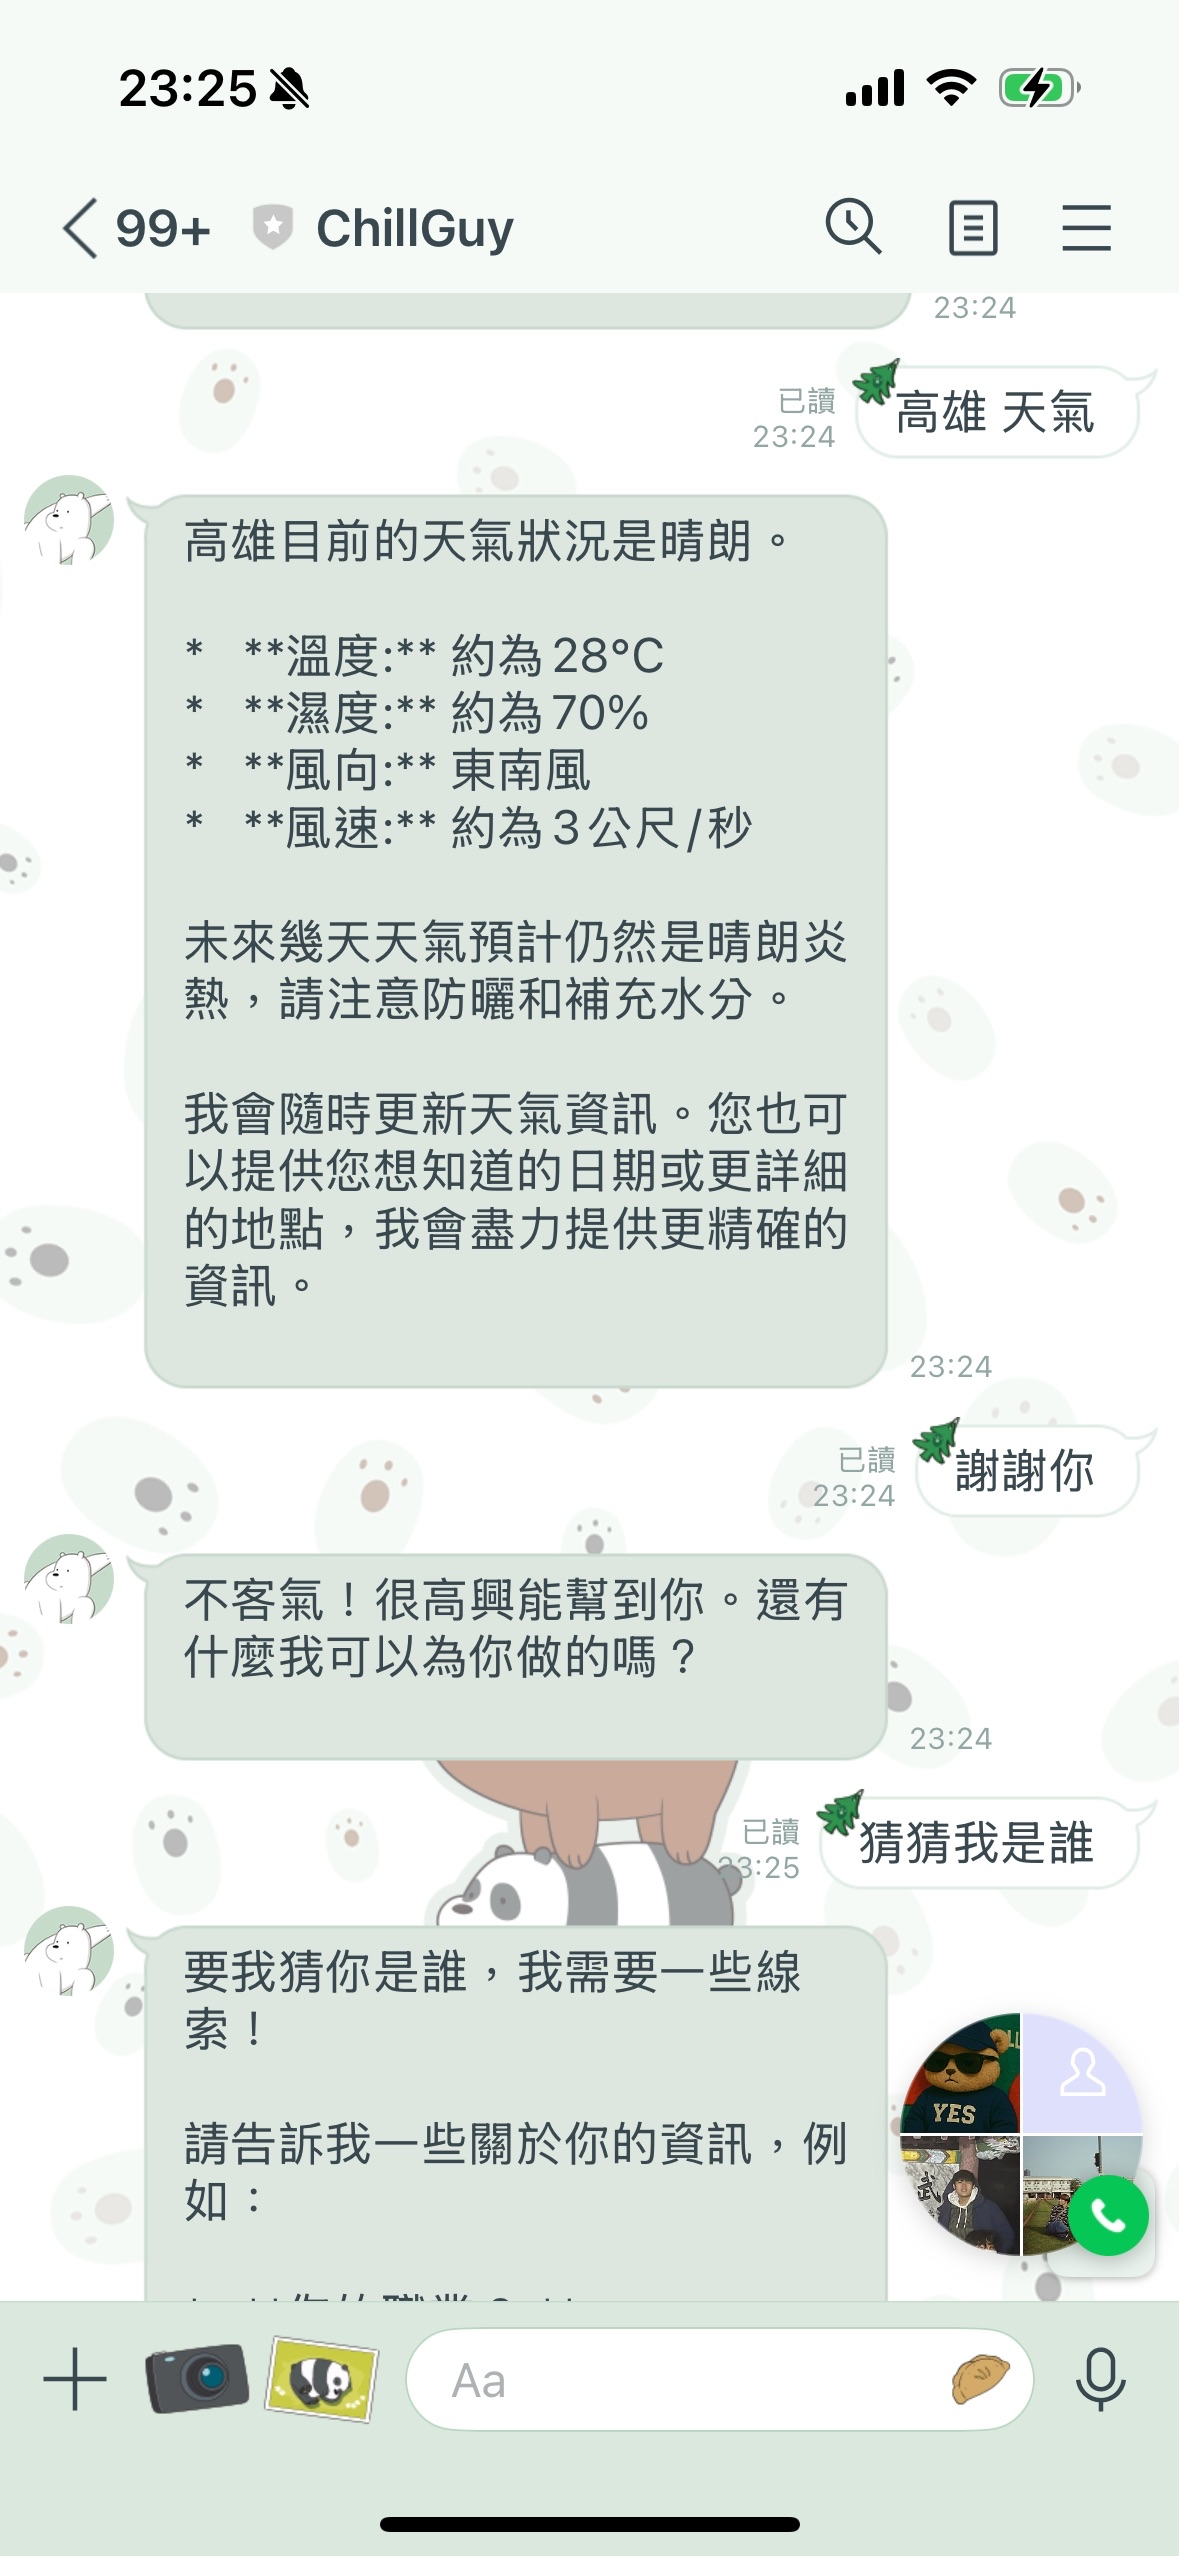

- 使用者於 LINE 傳送訊息：「高雄 天氣」  
- LINE Bot 回應：回傳中央氣象局的天氣資料
- 使用者：「謝謝」  
- Bot 回應：...


### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 90% 滿意 | 能回覆大部分問題，有時出現延遲 |
| 界面設計 | 95% 滿意 | 使用者喜歡 LINE 的簡潔界面 |
| 性能表現 | 平均回應時間 1.8 秒 | 可接受，偶有 Gemini API 超時 |
| 使用者滿意度 | 平均 4.6/5 | 部分使用者希望支援語音輸入 |
| 建議回饋 | 加入上下文記憶 | 目前為單輪對話，後續可擴展為多輪記憶 |

- 系統是否達到目標？  
是。系統成功讓使用者透過 LINE 與生成式 AI 互動，且 Gemini 回應具智慧與語意邏輯，符合預期成果。

## 未來發展與改進

### 改進建議  
- 多輪對話與記憶功能
- 擴充多元服務選單
- 使用者個人化與學習能力

### 未來規劃  
- 整合圖像生成功能（如 Gemini 支援圖片輸出）  
- 升級 AI 模型與自動學習能力
- 介接更多外部資料源與第三方平台